# EDA of the Papers by Subject dataset

The dataset used in this project can be found on Kaggle: [Papers by Subject](https://www.kaggle.com/datasets/arplusman/papers-by-subject?resource=download)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
import json

/opt/homebrew/Caskroom/miniconda/base/envs/mlops/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preparation

First we will prepare our data by removing unused columns, checking for nan or null value, and also removing duplicates.

In [2]:
papers = pd.read_csv('../data/arXiv-DataFrame.csv')

papers.head()

,Unnamed: 0,id,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category
0,0,cs/9308101v1,Dynamic Backtracking,Because of their occasional need to return to ...,M. L. Ginsberg,http://arxiv.org/pdf/cs/9308101v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
1,1,cs/9308102v1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,M. P. Wellman,http://arxiv.org/pdf/cs/9308102v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI']
2,2,cs/9309101v1,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,I. P. Gent,http://arxiv.org/pdf/cs/9309101v1,1993-09-01T00:00:00Z,1993-09-01T00:00:00Z,cs.AI,['cs.AI']
3,3,cs/9311101v1,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,F. Bergadano,http://arxiv.org/pdf/cs/9311101v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']
4,4,cs/9311102v1,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,J. C. Schlimmer,http://arxiv.org/pdf/cs/9311102v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI']


Here :
- `Unnamed` corresponds to an index, but it is not needed
- `id`  corresponds to the paper's id, but it is not needed

In [3]:
papers.drop(columns=['Unnamed: 0', 'id'], inplace=True, errors='ignore')

Let's check the different types, and the Null values

In [4]:
display(papers.columns)
display(papers.dtypes)

papers.replace(["", " ", "nan", "None"], np.nan, inplace=True)

papers.isnull().sum()

Index(['Title', 'Summary', 'Author', 'Link', 'Publish Date', 'Update Date',
       'Primary Category', 'Category'],
      dtype='object')

Title               object
Summary             object
Author              object
Link                object
Publish Date        object
Update Date         object
Primary Category    object
Category            object
dtype: object

Title               0
Summary             0
Author              0
Link                0
Publish Date        0
Update Date         0
Primary Category    0
Category            0
dtype: int64

Now let's check if there are any duplicates

In [5]:
# Count total duplicate rows across ALL 8 columns
print(papers.duplicated().sum())

# Show all duplicate rows (not just the 2nd occurrence),
# sorted by title and author for readability
papers[papers.duplicated(keep=False)] \
      .sort_values(['Title', 'Author'])

1075


,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category
23173,"""Tunneling"" Amplitudes of a Massless Quantum F...",We propose a method for the approximate comput...,Giovanni Modanese,http://arxiv.org/pdf/math-ph/9805003v1,1998-05-04T15:41:42Z,1998-05-04T15:41:42Z,math-ph,"['math-ph', 'math.MP']"
34373,"""Tunneling"" Amplitudes of a Massless Quantum F...",We propose a method for the approximate comput...,Giovanni Modanese,http://arxiv.org/pdf/math-ph/9805003v1,1998-05-04T15:41:42Z,1998-05-04T15:41:42Z,math-ph,"['math-ph', 'math.MP']"
23229,"(q,h)-analogue of Newton's binomial formula","In this letter, the (q,h)-analogue of Newton's...",H. B. Benaoum,http://arxiv.org/pdf/math-ph/9812028v1,1998-12-28T14:18:53Z,1998-12-28T14:18:53Z,math-ph,"['math-ph', 'math.MP']"
34429,"(q,h)-analogue of Newton's binomial formula","In this letter, the (q,h)-analogue of Newton's...",H. B. Benaoum,http://arxiv.org/pdf/math-ph/9812028v1,1998-12-28T14:18:53Z,1998-12-28T14:18:53Z,math-ph,"['math-ph', 'math.MP']"
23436,1.Classical and Modern Topology. 2.Topological...,Hystory of topology is discussed uncluding the...,Sergey P. Novikov,http://arxiv.org/pdf/math-ph/0004012v1,2000-04-11T16:58:33Z,2000-04-11T16:58:33Z,math-ph,"['math-ph', 'math.MP']"
...,...,...,...,...,...,...,...,...
21906,n-Channel Asymmetric Multiple-Description Latt...,We present analytical expressions for optimal ...,Jan Ostergaard,http://arxiv.org/pdf/cs/0508012v1,2005-08-02T07:52:14Z,2005-08-02T07:52:14Z,cs.IT,"['cs.IT', 'math.IT']"
7521,n-Channel Entropy-Constrained Multiple-Descrip...,In this paper we derive analytical expressions...,Jan Ostergaard,http://arxiv.org/pdf/cs/0602035v1,2006-02-09T08:51:57Z,2006-02-09T08:51:57Z,cs.IT,"['cs.IT', 'math.IT']"
22071,n-Channel Entropy-Constrained Multiple-Descrip...,In this paper we derive analytical expressions...,Jan Ostergaard,http://arxiv.org/pdf/cs/0602035v1,2006-02-09T08:51:57Z,2006-02-09T08:51:57Z,cs.IT,"['cs.IT', 'math.IT']"
27176,zoo: S3 Infrastructure for Regular and Irregul...,zoo is an R package providing an S3 class with...,A. Zeileis,http://arxiv.org/pdf/math/0505527v1,2005-05-25T04:46:35Z,2005-05-25T04:46:35Z,math.ST,"['math.ST', 'stat.TH']"


We drop the duplicates

In [6]:
display(papers.count())

papers.drop_duplicates(keep='first', inplace=True)

display(papers.count())

papers[papers.duplicated(keep=False)] \
      .sort_values(['Title', 'Author'])

Title               53474
Summary             53474
Author              53474
Link                53474
Publish Date        53474
Update Date         53474
Primary Category    53474
Category            53474
dtype: int64

Title               52399
Summary             52399
Author              52399
Link                52399
Publish Date        52399
Update Date         52399
Primary Category    52399
Category            52399
dtype: int64

,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category


In [7]:
papers.nunique()


Title               52315
Summary             52266
Author              35189
Link                52399
Publish Date        51494
Update Date         51505
Primary Category      154
Category             8670
dtype: int64


Let's now see the different distributions for the authors and the primary Category.

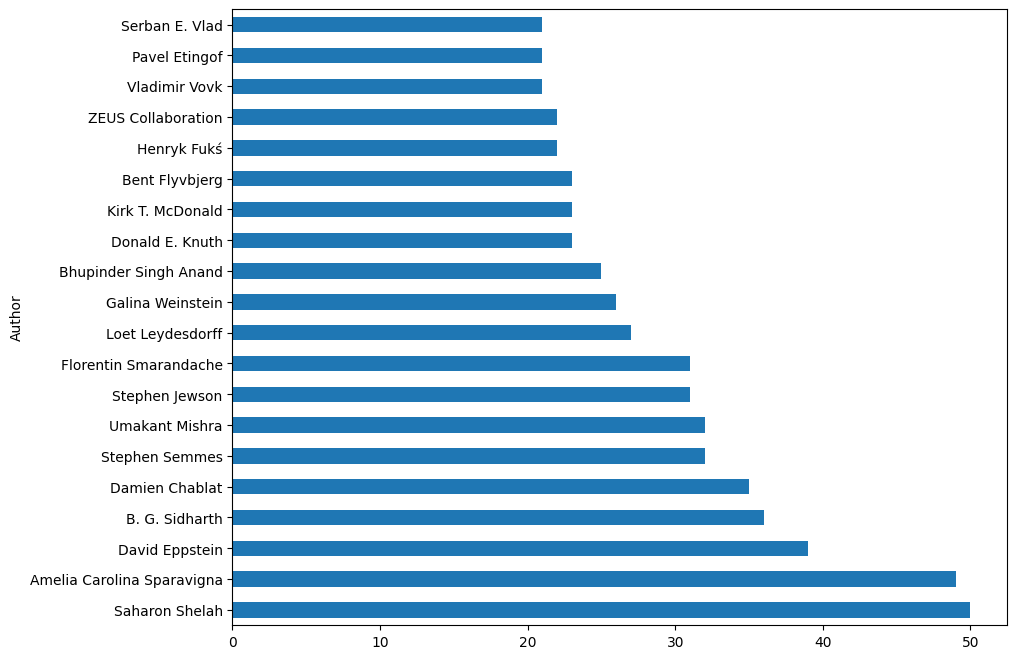

In [8]:
papers['Author'].value_counts().head(20).plot(kind='barh', figsize=(10,8))
plt.show()

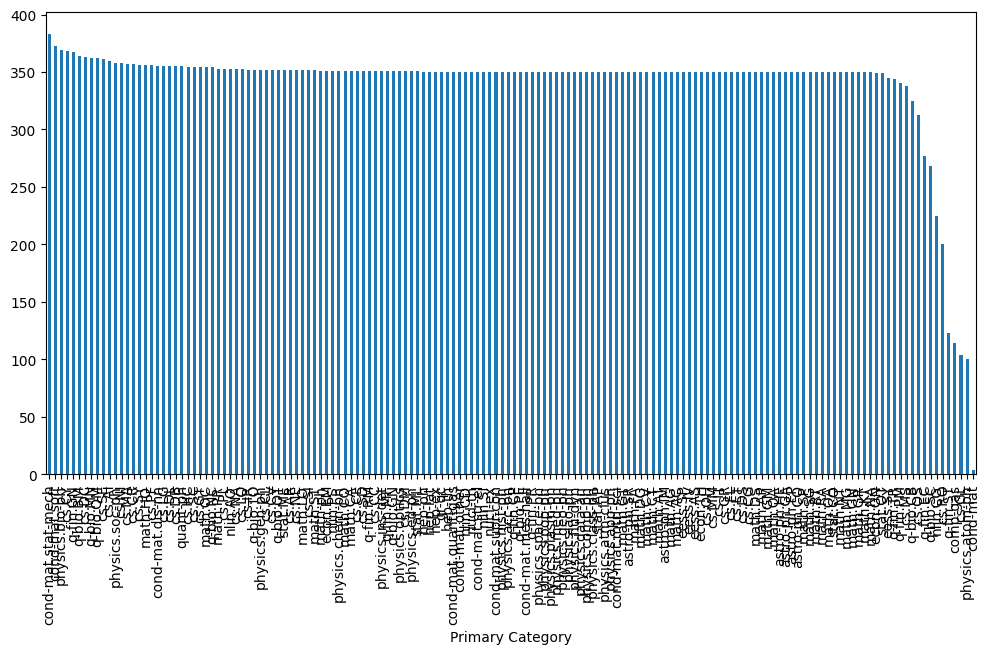

In [9]:
papers['Primary Category'].value_counts().plot(kind='bar', figsize=(12,6))
plt.show()

As we can see the average number of time a category appears is around 350.

In [9]:
# Count of papers per category
category_counts = papers['Primary Category'].value_counts()
print("Number of papers per category:")
print(category_counts)

Number of papers per category:
Primary Category
cond-mat.stat-mech    383
cond-mat.soft         373
physics.bio-ph        369
cs.CY                 368
q-fin.GN              367
                     ... 
q-fin.ST              123
comp-gas              114
cs.GL                 104
physics.atom-ph       100
cond-mat                4
Name: count, Length: 154, dtype: int64


As the data is very big for our computer, we will be using a small subset of the data by thresholding any genre to 100 papers max, and every authors to 20 papers max.

In [10]:
# -------------------------------
# 1. Limit authors to max 20 papers
# -------------------------------
max_author_count = 20

def truncate_group(df, group_col, max_count):
    truncated_df = df.groupby(group_col).head(max_count)
    print(f"After truncating {group_col}: {len(truncated_df)} rows")
    return truncated_df

papers = truncate_group(papers, 'Author', max_author_count)

# -------------------------------
# 2. Limit categories to max 100 papers
# -------------------------------
max_category_count = 100
papers = truncate_group(papers, 'Primary Category', max_category_count)

# Check counts after truncation
print(papers['Author'].value_counts().max())          # Should be <= 20
print(papers['Primary Category'].value_counts().max()) # Should be <= 100


After truncating Author: 52210 rows
After truncating Primary Category: 15304 rows
20
100


In [ ]:
with open("map_category.json", "r") as f:
    category_map = json.load(f)

papers["Category"] = papers["Primary Category"].map(category_map).fillna("Other")

In [21]:
papers["Category"].nunique()

153

# Content Based

In [12]:
# Combine Title and Summary
papers['text'] = papers['Title'].fillna('') + " " + papers['Summary'].fillna('')

try:
    # Try to load existing embeddings
    text_embeddings = np.load('text_embeddings.npy')
    if not isinstance(text_embeddings, np.ndarray):
        raise ValueError("Loaded embeddings are not a NumPy array. Recomputing embeddings.")
except (FileNotFoundError, ValueError):
    # If file doesn't exist or is invalid, compute embeddings
    model = SentenceTransformer('all-MiniLM-L6-v2') 
    text_embeddings = model.encode(papers['text'].tolist(), show_progress_bar=True)
    np.save('text_embeddings.npy', text_embeddings)


In [13]:
papers.to_csv('papers.csv', index=False)

In [ ]:
categorical_cols = ['Author', 'Primary Category', 'Category']

try:
    # Try to load existing categorical embeddings
    cat_embeddings = np.load('cat_embeddings.npy', allow_pickle=True)
    if not isinstance(cat_embeddings, np.ndarray):
        raise ValueError("Loaded embeddings are not a NumPy array. Recomputing embeddings.")
except (FileNotFoundError, ValueError):
    # If file doesn't exist or is invalid, compute embeddings
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    cat_embeddings = encoder.fit_transform(papers[categorical_cols].fillna(''))
    np.save('cat_embeddings.npy', cat_embeddings)

In [15]:
papers

,Title,Summary,Author,Link,Publish Date,Update Date,Primary Category,Category,text
0,Dynamic Backtracking,Because of their occasional need to return to ...,M. L. Ginsberg,http://arxiv.org/pdf/cs/9308101v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI'],Dynamic Backtracking Because of their occasion...
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,M. P. Wellman,http://arxiv.org/pdf/cs/9308102v1,1993-08-01T00:00:00Z,1993-08-01T00:00:00Z,cs.AI,['cs.AI'],A Market-Oriented Programming Environment and ...
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,I. P. Gent,http://arxiv.org/pdf/cs/9309101v1,1993-09-01T00:00:00Z,1993-09-01T00:00:00Z,cs.AI,['cs.AI'],An Empirical Analysis of Search in GSAT We des...
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,F. Bergadano,http://arxiv.org/pdf/cs/9311101v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI'],The Difficulties of Learning Logic Programs wi...
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,J. C. Schlimmer,http://arxiv.org/pdf/cs/9311102v1,1993-11-01T00:00:00Z,1993-11-01T00:00:00Z,cs.AI,['cs.AI'],Software Agents: Completing Patterns and Const...
...,...,...,...,...,...,...,...,...,...
52868,Nonparametric Spherical Regression Using Diffe...,Spherical regression explores relationships be...,Michael Rosenthal,http://arxiv.org/pdf/1702.00823v1,2017-02-02T20:46:28Z,2017-02-02T20:46:28Z,stat.OT,['stat.OT'],Nonparametric Spherical Regression Using Diffe...
52869,MH370 Burst Frequency Offset Analysis and Impl...,Malaysian Airlines flight MH370 veered off cou...,Ian D. Holland,http://arxiv.org/pdf/1702.02432v3,2017-02-07T07:58:35Z,2018-01-15T06:27:28Z,stat.OT,['stat.OT'],MH370 Burst Frequency Offset Analysis and Impl...
52870,Social Big Data Analytics of Consumer Choices:...,This dissertation examines three distinct big ...,Meisam Hejazi Nia,http://arxiv.org/pdf/1702.07074v1,2017-02-23T02:39:59Z,2017-02-23T02:39:59Z,stat.OT,['stat.OT'],Social Big Data Analytics of Consumer Choices:...
52871,J.B.S. Haldane Could Have Done Better,In a review on the contribution of J.B.S. Hald...,Claus Vogl,http://arxiv.org/pdf/1702.08261v1,2017-02-27T13:02:58Z,2017-02-27T13:02:58Z,stat.OT,['stat.OT'],J.B.S. Haldane Could Have Done Better In a rev...


In [ ]:
combined_embeddings = np.hstack([text_embeddings, cat_embeddings])
x&d
similarity_matrix = cosine_similarity(combined_embeddings)

In [17]:
np.save('similarity_matrix.npy', similarity_matrix)

In [18]:
def recommend_articles(article_index, top_n=5):
    similarity_scores = similarity_matrix[article_index]
    similar_indices = similarity_scores.argsort()[::-1][1:top_n+1]
    return papers.iloc[similar_indices][['Title', 'Author', 'Primary Category', 'Category']]

article_idx = 0
print("Original Article:\n", papers.iloc[article_idx])
print("\nRecommended Articles:\n", recommend_articles(article_idx, top_n=5))

Original Article:
 Title                                            Dynamic Backtracking
Summary             Because of their occasional need to return to ...
Author                                                 M. L. Ginsberg
Link                                http://arxiv.org/pdf/cs/9308101v1
Publish Date                                     1993-08-01T00:00:00Z
Update Date                                      1993-08-01T00:00:00Z
Primary Category                                                cs.AI
Category                                                    ['cs.AI']
text                Dynamic Backtracking Because of their occasion...
Name: 0, dtype: object

Recommended Articles:
                                                 Title       Author  \
66  Accelerating Partial-Order Planners: Some Tech...  A. Gerevini   
91        Bidirectional Heuristic Search Reconsidered    H. Kaindl   
90          When Gravity Fails: Local Search Topology     J. Frank   
46  The Design and Exper